<a href="https://colab.research.google.com/github/AmirJamarani/Glaucoma-Detection/blob/main/Glaucoma_Detection_using_Clinical_Notes_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow scikit-learn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.metrics import roc_auc_score


**Hi, please replace the data, file location in the code with the dataset you have to run the codes succeffully. Also, you need to convert it to the XLSX from CSV file**

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your own dataset here please
data = pd.read_excel('/content/clinical_notes.xlsx')

data['note'] = data['note'].fillna('')

train_data = data[data['use'] == 'training']
val_data = data[data['use'] == 'validation']
test_data = data[data['use'] == 'test']

text_data = pd.concat([train_data['note'], train_data['gpt4_summary'],
                       val_data['note'], val_data['gpt4_summary'],
                       test_data['note'], test_data['gpt4_summary']])

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(text_data)

max_length = 100

def preprocess_text(data, tokenizer, max_length):
    notes_seq = pad_sequences(tokenizer.texts_to_sequences(data['note']), maxlen=max_length, padding='post')
    summaries_seq = pad_sequences(tokenizer.texts_to_sequences(data['gpt4_summary']), maxlen=max_length, padding='post')
    return notes_seq, summaries_seq

X_train_note, X_train_summary = preprocess_text(train_data, tokenizer, max_length)
X_val_note, X_val_summary = preprocess_text(val_data, tokenizer, max_length)
X_test_note, X_test_summary = preprocess_text(test_data, tokenizer, max_length)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Concatenate


embedding_dim = 64


def create_lstm_model(input_length, embedding_dim):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=10000, output_dim=embedding_dim, input_length=input_length)(inputs)
    x = LSTM(64)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model


def create_cnn_model(input_length, embedding_dim):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=10000, output_dim=embedding_dim, input_length=input_length)(inputs)
    x = Conv1D(128, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model


lstm_model = create_lstm_model(max_length, embedding_dim)
cnn_model = create_cnn_model(max_length, embedding_dim)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Convert glaucoma column to numeric values (0 and 1)
train_data['glaucoma'] = train_data['glaucoma'].apply(lambda x: 1 if x == 'yes' else 0)
val_data['glaucoma'] = val_data['glaucoma'].apply(lambda x: 1 if x == 'yes' else 0)
test_data['glaucoma'] = test_data['glaucoma'].apply(lambda x: 1 if x == 'yes' else 0)


<ipython-input-5-393477e3b6e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['glaucoma'] = train_data['glaucoma'].apply(lambda x: 1 if x == 'yes' else 0)
<ipython-input-5-393477e3b6e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['glaucoma'] = val_data['glaucoma'].apply(lambda x: 1 if x == 'yes' else 0)
<ipython-input-5-393477e3b6e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [ ]:
# LSTM model
lstm_model.fit(X_train_note, train_data['glaucoma'], validation_data=(X_val_note, val_data['glaucoma']), epochs=5, batch_size=32)

# CNN model
cnn_model.fit(X_train_note, train_data['glaucoma'], validation_data=(X_val_note, val_data['glaucoma']), epochs=5, batch_size=32)


Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - AUC: 0.5563 - loss: 0.6875 - val_AUC: 0.6296 - val_loss: 0.6658
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - AUC: 0.6918 - loss: 0.6341 - val_AUC: 0.7173 - val_loss: 0.6253
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - AUC: 0.7340 - loss: 0.6067 - val_AUC: 0.7128 - val_loss: 0.6256
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - AUC: 0.8254 - loss: 0.5140 - val_AUC: 0.7126 - val_loss: 0.6469
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - AUC: 0.8307 - loss: 0.5008 - val_AUC: 0.7313 - val_loss: 0.6482
Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 0.6575 - loss: 0.6480 - val_AUC: 0.7935 - val_loss: 0.5457
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - AUC: 0.8604 - loss: 0.4709 - val_AUC: 0.8187 - val_loss: 0.5137
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 0.9258 - loss: 0.3607 - val_AUC: 0.8265 - val_loss: 0.5137
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/ste

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_auc_by_race(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    overall_predictions = np.ravel(model.predict(X_test))
    overall_auc = roc_auc_score(test_data[target_column], overall_predictions)


    race_aucs = {}
    for race in [0, 1, 2]:  # Asian = 0, Black = 1, White = 2
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:
            race_predictions = overall_predictions[race_indices]
            race_true_labels = test_data.loc[race_indices, target_column]
            race_auc = roc_auc_score(race_true_labels, race_predictions)
            race_aucs[race] = race_auc
        else:
            race_aucs[race] = None

    return overall_auc, race_aucs


overall_auc, race_aucs = calculate_auc_by_race(lstm_model, X_test_note, test_data)
print("Overall AUC:", overall_auc)
print("AUCs by Race:", race_aucs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Overall AUC: 0.7585697834154267
AUCs by Race: {0: None, 1: None, 2: None}


In [ ]:

print(test_data['race'].unique())


['white' 'asian' 'black']


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_auc_by_race(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    test_data.reset_index(drop=True, inplace=True)


    overall_predictions = np.ravel(model.predict(X_test))


    print("Overall Predictions Shape:", overall_predictions.shape)
    print("Test Data Shape:", test_data.shape)

    overall_auc = roc_auc_score(test_data[target_column], overall_predictions)


    race_aucs = {}
    race_labels = ['white', 'asian', 'black']

    for race in race_labels:
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:

            race_predictions = overall_predictions[race_indices.to_list()]
            race_true_labels = test_data.loc[race_indices, target_column]
            race_auc = roc_auc_score(race_true_labels, race_predictions)
            race_aucs[race] = race_auc
        else:
            race_aucs[race] = None

    return overall_auc, race_aucs

overall_auc, race_aucs = calculate_auc_by_race(lstm_model, X_test_note, test_data)
print("Overall AUC:", overall_auc)
print("AUCs by Race:", race_aucs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Overall Predictions Shape: (2000,)
Test Data Shape: (2000, 10)
Overall AUC: 0.7585697834154267
AUCs by Race: {'white': 0.7467992381881892, 'asian': 0.8338407306521392, 'black': 0.7805654371840479}


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


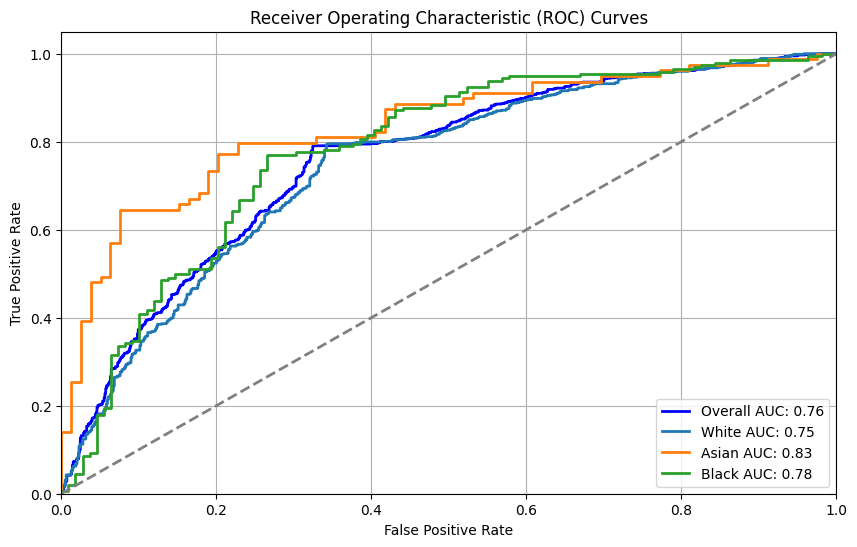

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    overall_predictions = np.ravel(model.predict(X_test))


    plt.figure(figsize=(10, 6))


    fpr, tpr, _ = roc_curve(test_data[target_column], overall_predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2, label='Overall AUC: {:.2f}'.format(roc_auc))


    race_labels = ['white', 'asian', 'black']
    for race in race_labels:
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:
            race_predictions = overall_predictions[race_indices]
            race_true_labels = test_data.loc[race_indices, target_column]
            fpr, tpr, _ = roc_curve(race_true_labels, race_predictions)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label='{} AUC: {:.2f}'.format(race.capitalize(), roc_auc))

    # Plotting settings
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


plot_roc_curves(lstm_model, X_test_note, test_data)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


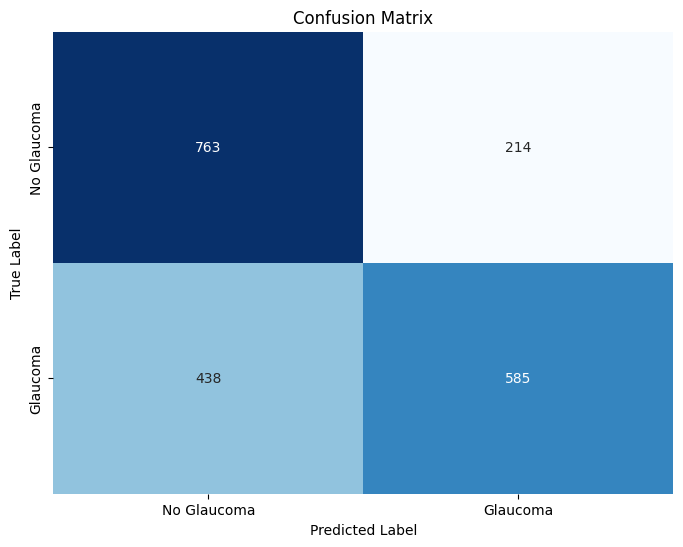

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, test_data, target_column='glaucoma'):

    predictions_prob = model.predict(X_test)
    predictions = (predictions_prob > 0.5).astype(int)


    cm = confusion_matrix(test_data[target_column], predictions)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Glaucoma', 'Glaucoma'],
                yticklabels=['No Glaucoma', 'Glaucoma'])


    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(lstm_model, X_test_note, test_data)
